In [35]:
## Imports
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import folium
import json
import glob
import os
import requests
import scipy
from matplotlib.colors import *
from sklearn.model_selection import *
from sklearn.preprocessing import *
from sklearn.linear_model import *
from sklearn.ensemble import *
from sklearn.metrics import *
from sklearn.externals import *
from scipy.stats import *
from dateutil.parser import parse
import datetime as dt
import cleaningtool as ct
pd.options.mode.chained_assignment = None  # default='warn'

from helpers import *

# Exploration
#### This section notebook outlines initial exploration of the dataset.

## Task 1: Explore subjects feature
We want to answer some basic questions about the subject feature. This might expose interesting topics to analyze in greater depth. This creates multiple descriptive sub-tasks. We break this task down into the follow sub-tasks:
- Find all unique subjects. How many different subjects are there? (what level of granularity are we getting here?)
- Find which subjects have more than 100 instances within the dataset.
- Find a way to visualize how truth relates to this feature.

In [36]:
## Define paths
DATA_FOLDER = './data/'
TRAIN_PATH = DATA_FOLDER + 'train.tsv'
TEST_PATH = DATA_FOLDER + 'test.tsv'
VALID_PATH = DATA_FOLDER + 'valid.tsv'

In [37]:
CLEAN_TRAIN = DATA_FOLDER + "train_clean.txt"
CLEAN_TEST = DATA_FOLDER + "test_clean.txt"
CLEAN_VALID = DATA_FOLDER + "valid_clean.txt"

In [38]:
# Data Loading

cols = ["ID", "label", "statement", "subject", "speaker", "job", "state", "party", "barely_true_cts",
        "false_cts", "half_true_cts", "mostly_true_cts", "pants_on_fire_cts", "context"]

train_data = pd.read_table(TRAIN_PATH, header=None) 
train_data.columns = cols

test_data = pd.read_table(TEST_PATH, header=None)
test_data.columns = cols

valid_data = pd.read_table(VALID_PATH, header=None)
valid_data.columns = cols

In [39]:
## Load raw data

df_raw = pd.concat([train_data, test_data, valid_data], axis=0, sort=False)
df_raw = df_raw.sample(frac=1).reset_index()
df_raw = ct.clean_df(df_raw)
df_raw.head(2)

,index,ID,label,statement,subject,speaker,job,state,party,barely_true_cts,false_cts,half_true_cts,mostly_true_cts,pants_on_fire_cts,context
0,1951,13278.json,false,State Department officials actually directed c...,ethics,mike-pence,Governor,Indiana,republican,8.0,10.0,12.0,5.0,0.0,Ad
1,5065,4414.json,half-true,Michael Dukakis created jobs three times faste...,jobs,rick-perry,Governor,Texas,republican,30.0,30.0,42.0,23.0,18.0,Debate


In [40]:
## Check types and shape
print(df_raw.dtypes)
print(df_raw.shape)

index                  int64
ID                    object
label                 object
statement             object
subject               object
speaker               object
job                   object
state                 object
party                 object
barely_true_cts      float64
false_cts            float64
half_true_cts        float64
mostly_true_cts      float64
pants_on_fire_cts    float64
context               object
dtype: object
(12791, 15)


In [41]:
## Help put data in useful form - split topics as list and separate into new rows for grouping
## Split subjects into lists
def subject_split(df):
    '''
    Splits dataframe to have entries for each subject in cases where the original entry had multiple subjects.
    Params - df : Dataframe to operate upon
    Returns - new Dataframe formatted as specified
    '''
    df = df.copy()
    df["subject"] = df["subject"].apply(lambda x : str(x).lower().split(","))
    ## Create a dataframe of all subjects
    subjects = df.subject.apply(pd.Series)
    new_cols = list(df.columns.values)
    new_cols.remove("subject")

    ## Now merge with original frame to create separate columns for each subject
    ## Then melt so that each entry exists under several subjects
    df = subjects.merge(df, right_index = True, left_index = True) \
        .drop(["subject"], axis = 1) \
        .melt(id_vars = new_cols, value_name = "subject") \
        .drop("variable", axis = 1) \
    
    return df

In [42]:
subject_df = subject_split(df_raw)

set_of_subjects = set(subject_df['subject'])
    
print("There are %d unique subjects" % len(set_of_subjects))
print("Some sample subjects include:\n", list(set_of_subjects)[:5])

There are 146 unique subjects
Some sample subjects include:
 [nan, 'states', 'families', 'nuclear', 'baseball']


In [43]:
subject_df.head(2)

,index,ID,label,statement,speaker,job,state,party,barely_true_cts,false_cts,half_true_cts,mostly_true_cts,pants_on_fire_cts,context,subject
0,1951,13278.json,false,State Department officials actually directed c...,mike-pence,Governor,Indiana,republican,8.0,10.0,12.0,5.0,0.0,Ad,ethics
1,5065,4414.json,half-true,Michael Dukakis created jobs three times faste...,rick-perry,Governor,Texas,republican,30.0,30.0,42.0,23.0,18.0,Debate,jobs


We notice that many subjects have very few instances within the dataset. 
We want to limit ourselves to subjects that are mentioned with reasonable frequency.
We choose to only include subjects that appear more than 100 times.

In [44]:
subject_counts = subject_df.groupby("subject").count()
subjects_over_100 = subject_counts.where(subject_counts['ID'] > 100).dropna().index
subject_df = subject_df[subject_df['subject'].isin(subjects_over_100)]

print("There are %d unique subjects that have over 100 corresponding statements" % len(subjects_over_100))

There are 69 unique subjects that have over 100 corresponding statements


By limiting out subjects to those that appear frequently, we have a small enough set to do some useful visual analysis.

In [45]:
def by_label(df, column):
    return df.groupby([column,"label"]).agg({"ID" : "count"})

breakdown = by_label(subject_df, 'subject')
breakdown.head()

ID
subject       label          
abc-news-week barely-true  13
              false        22
              half-true    30
              mostly-true  31
              pants-fire    1

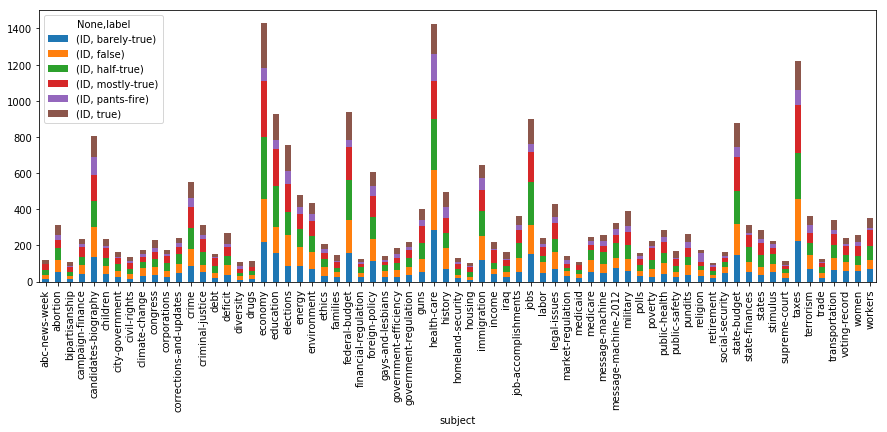

In [46]:
breakdown.unstack().plot(kind='bar', stacked=True, figsize=(15,5))

In [47]:
def normalize(df, column):
    bd_norm = df.reset_index()
    bd_norm = bd_norm.set_index([column,'label'])['ID'].unstack(fill_value=0)

    row_sums = bd_norm.sum(axis=1)
    for row_ind in range(len(bd_norm.index)):
        bd_norm.iloc[row_ind] /= row_sums[row_ind]

    bd_norm = bd_norm.stack().reset_index(name='Percent').set_index([column, 'label'])
    return bd_norm

bd_norm = normalize(breakdown, 'subject')

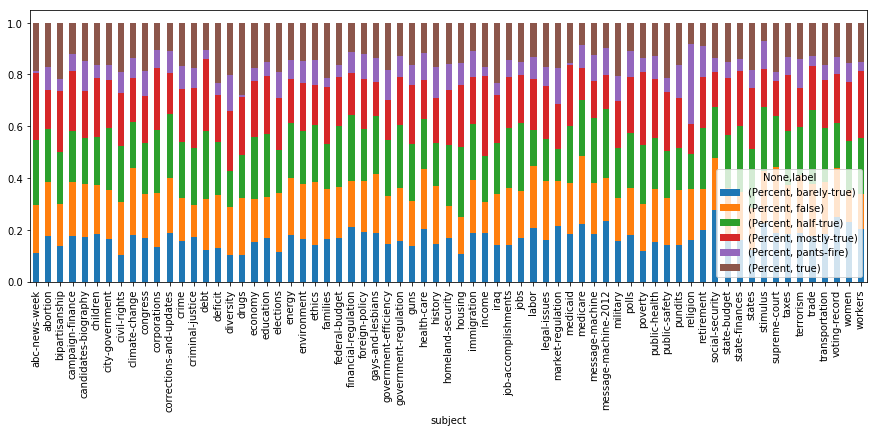

In [48]:
bd_norm.unstack().plot(kind='bar', stacked=True, figsize=(15,5))

Above, we can see from our un-normalized plot the distribution of topics as well as their respective distribution of truth classifications. From the normalized plot, we see can more easily see the distribution of truth classifications.

We may be interested in making a simpler classification, such as 'false' versus 'not false'. In this way, we regard 'pants-fire' and 'false' as a false tags, and all others are those statements with at least a small degree of truth within.

In [49]:
def transform_tf(df, column):
    tf_breakdown = df.copy()
    tf_breakdown['false'] = ~(tf_breakdown['label'].isin(['false', 'pants-fire', 'barely-true']))

    tf_breakdown = tf_breakdown.groupby([column,"false"]).agg({"ID" : "count"})
    return tf_breakdown

tf_breakdown = transform_tf(subject_df, 'subject')

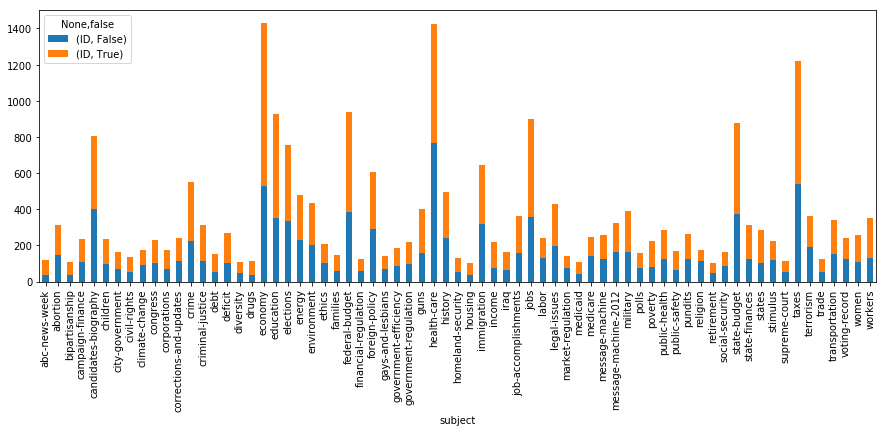

In [50]:
tf_breakdown.unstack().plot(kind='bar', stacked=True, figsize=(15,5))

In [51]:
def normalize_tf(df, column):
    bd_norm = df.reset_index()
    bd_norm = bd_norm.set_index([column,'false'])['ID'].unstack(fill_value=0)

    row_sums = bd_norm.sum(axis=1)
    for row_ind in range(len(bd_norm.index)):
        bd_norm.iloc[row_ind] /= row_sums[row_ind]

    bd_norm = bd_norm.stack().reset_index(name='Percent').set_index([column, 'false'])
    return bd_norm

bd_norm = normalize_tf(tf_breakdown, 'subject')
bd_norm.head()

Percent
subject        false          
abc-news-week  False  0.302521
               True   0.697479
abortion       False  0.469649
               True   0.530351
bipartisanship False  0.345455

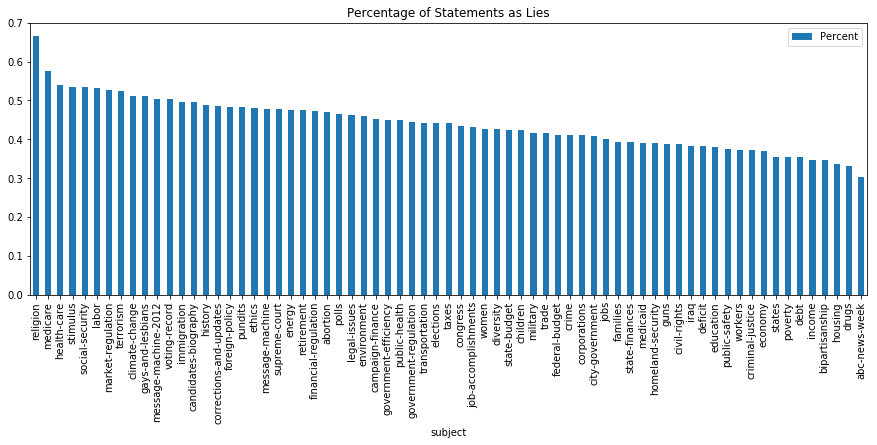

In [52]:
def plot_truthfulness(df, column):
    df_ri = df.reset_index()
    tf = df_ri[~df_ri['false']][[column, 'Percent']]
    tf = tf.sort_values('Percent', ascending=False)
    tf.plot(x=column,kind='bar', title="Percentage of Statements as Lies", figsize=(15,5))
    
plot_truthfulness(bd_norm, "subject")

### Task 1: Interpretation
We note that of the topics discussed often in the liar dataset, medicare and terrorism have the most lies. While we note the percentages are quite high, we note that statements from this dataset are by dy default disputed so this is not unexpected. However, assuming the dataset was not gathered with a particularly subject bias, the relative truth rate between subjects could be meaningful. It is possibly worth looking in to Note that this analysis does not consider consider half-true as a lie.

## Task 2: Explore speaker feature
We want to answer some basic questions about the speaker feature. This might expose interesting topics to analyze in greater depth because it is likely that different speakers have different levels of truthfulness. This creates multiple descriptive sub-tasks. We break this task down into the follow sub-tasks:
- Find all unique speakers. How many different speakers are there?
- Find which speakers have more than 50 instances within the dataset.
- Find a way to visualize how truth relates to this feature.

In [53]:
speakers_df = df_raw.copy()
speakers = speakers_df['speaker'].unique()
print("There are %d unique speakers" % len(speakers))
print("Some sample speakers include:\n", speakers[:5])

There are 3310 unique speakers
Some sample speakers include:
 ['mike-pence' 'rick-perry' 'house-republicans' 'ben-shapiro'
 'scott-walker']


In [54]:
speakers_cts = speakers_df.groupby("speaker").statement.count()
speakers = speakers_cts[speakers_cts > 50]
print("There are %d unique speakers who appear more than 50 times within the dataset" % len(speakers))
print("Some sample speakers include:\n", speakers[:5])

There are 29 unique speakers who appear more than 50 times within the dataset
Some sample speakers include:
 speaker
barack-obama     611
bernie-s         106
blog-posting      81
chain-email      178
charlie-crist     90
Name: statement, dtype: int64


In [55]:
## Limit ourselves to only prominent speakers for visualization
speakers_df = speakers_df[speakers_df['speaker'].isin(speakers.keys())]

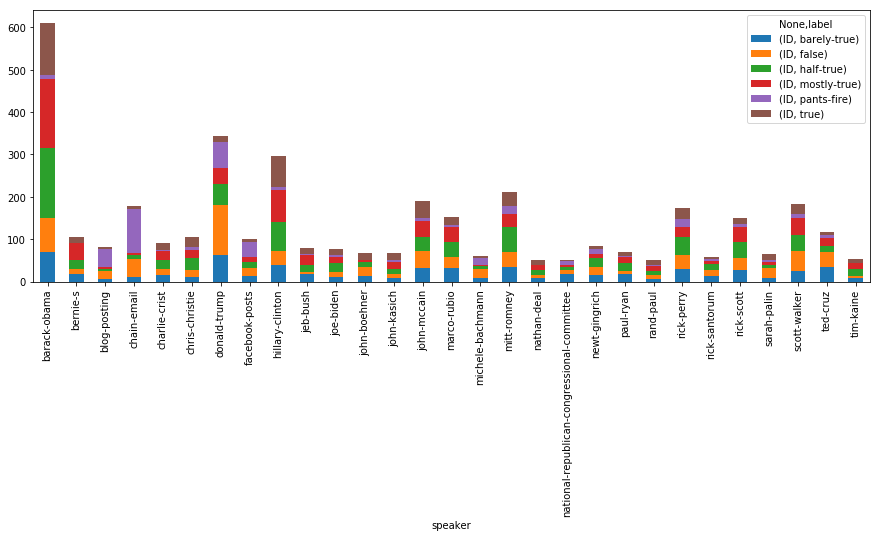

In [56]:
breakdown = by_label(speakers_df, 'speaker')
breakdown.unstack().plot(kind='bar', stacked=True, figsize=(15,5))

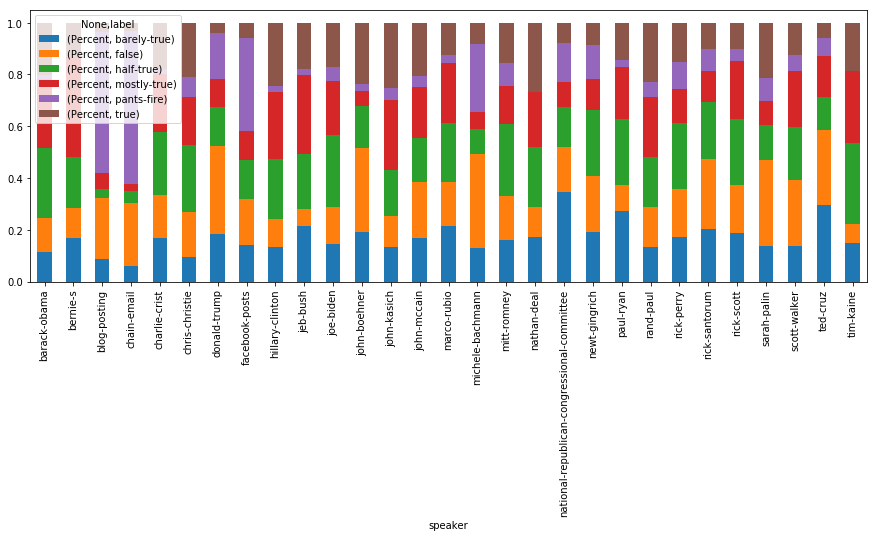

In [57]:
bd_norm = normalize(breakdown, 'speaker')
bd_norm.unstack().plot(kind='bar', stacked=True, figsize=(15,5))

From this, we can see a few interesting findings. It seems that Facebook posts, chain emails and Donald Trump are trastically more likely to be 'pants-fire' lies, which are the most obvious and blatantly false types of lies of the possible labels. We also see that most other speakers maintain a very much smaller 'pants-fire' rate.

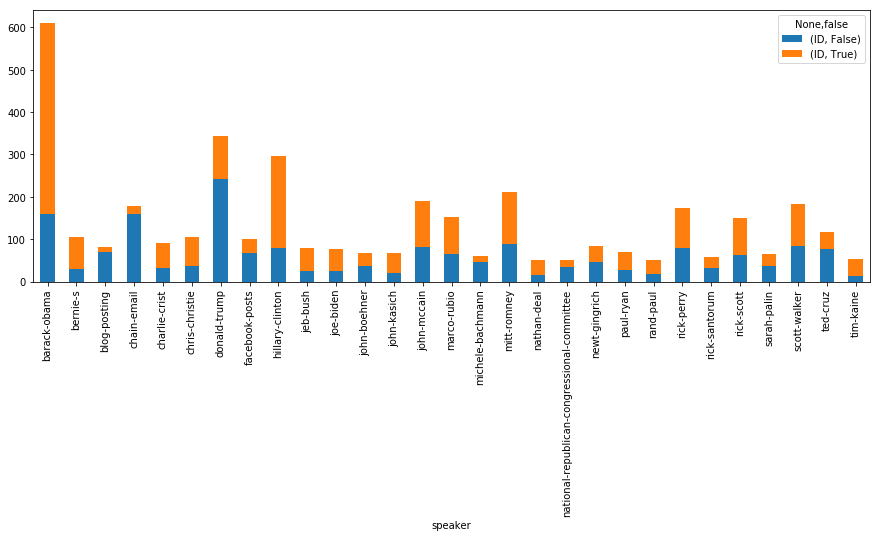

In [58]:
tf_breakdown = transform_tf(speakers_df, 'speaker')
tf_breakdown.unstack().plot(kind='bar', stacked=True, figsize=(15,5))

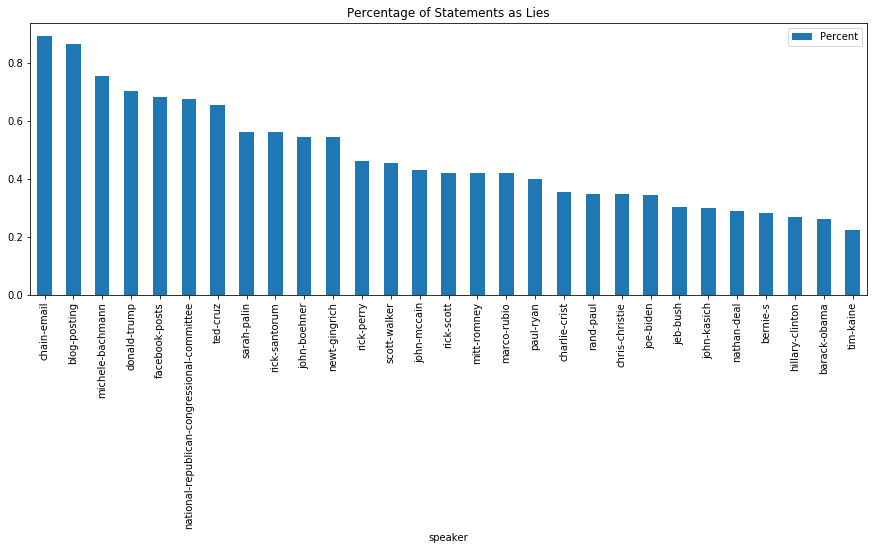

In [59]:
bd_norm = normalize_tf(tf_breakdown, 'speaker')
plot_truthfulness(bd_norm, 'speaker')

### Task 2: Interpretation
In breaking down our dataset by the speakers, we see some interesting trends, due to the fact that speakers can be both people as well as websites/communication mediums. In looking at our most prominent sources, we see that anonymous media tend to have the highest untruthfulness rate. The only person who who lies more than one of the anonymous media is Donald Trump, whose overall rate of lying is greater than Facebook posts. That said, we also see that Facebook posts proportionally are more 'pants-fire' type lies. Donald Trump has proportionally fewer 'pants-fire' lies, but drastically more 'false' lies.

We also note that chain-emails are heinously untruthful. Of the ones examined in this dataset, over 80% are either false or 'pants-fire' false.

## Task 3: Locational analysis
We note that our dataframe has state information for each of the statements. We would like to see how the rate of lies varies within states by:
- Creating a heatmap of lies from the dataset.

In [60]:
# Computing percentage of lies

states_lies_count = df_raw[df_raw.label.isin(["false", "pants-fire", "barely-true"])].groupby('state').state.count()
states_count = df_raw.groupby('state').state.count()
states_tot_false = pd.concat([states_count, states_lies_count], axis=1, sort=True).dropna()
states_tot_false.columns = ['count_tot', 'count_false']
states_tot_false.count_false = states_tot_false.count_false.astype('int64')
states_tot_false['perc_lies'] = (states_tot_false.count_false / states_tot_false.count_tot) * 100
states_tot_false.reset_index(inplace=True)
states_tot_false.columns = ['state', 'count_tot', 'count_false', 'perc_lies']
states_tot_false.head()

,state,count_tot,count_false,perc_lies
0,Alabama,18,11,61.111111
1,Alaska,81,46,56.790123
2,Arizona,228,97,42.543860
3,Arkansas,103,42,40.776699
4,California,180,70,38.888889


In [61]:
state_geo_path = r'us-states.json'
geo_json_data = json.load(open(state_geo_path))

get_state_names = lambda x: x['properties']['name']
geo_states = set(map(get_state_names, geo_json_data['features']))
df_states = set(states_tot_false['state'])
to_add = geo_states - df_states

In [62]:
us_map = folium.Map(location=[48, -102], zoom_start=3)
us_map.choropleth(geo_data=geo_json_data, data=states_tot_false,
             columns=['state', 'perc_lies'],
             key_on='feature.properties.name',
             fill_color='BuPu', fill_opacity=0.7, line_opacity=0.2,
             legend_name='Percentage of lies (%)')

us_map.save("us_map_lies.html")
us_map

If the map doesn't display, please look at the html file "us_map_lies.html" for the visualization.

### Task 3: Interpretation
From here we see lies being more prominent in Montana than anywhere else, while Tennessee, Mississippi, West Virginia also are prominent. Ultimately, we do not see much geographical clustering, and even if we thought to note the general trend for higher lie rate in southern states, this does not seem to hold very well considering Arkansas and North Carolina. This may ultimately just be a heatmap of the states of the political speakers within the dataset, so this may not be useful in our further analysis.

## Task 4: Explore job feature
The dataframe contains jobs of each of the speakers. We will perform similar analysis as with our other features, in order to see how well job analysis relates to truthfulness:
- Find all unique jobs. How many different subjects are there?
- Find a way to visualize how truth relates to this feature.

In [64]:
jobs_df = df_raw.copy()
jobs = jobs_df['job'].unique()
print("There are %d unique jobs" % len(jobs))
print("Some sample jobs include:\n", jobs[:5])

There are 804 unique jobs
Some sample jobs include:
 ['Governor' nan 'Milwaukee County Executive' 'President' 'Mayor']


Similar to above, there are too many unique jobs to query. So we will look at the most common jobs.

In [65]:
job_cts = jobs_df.groupby("job").statement.count()
jobs = job_cts[job_cts > 20]
print("There are %d unique jobs who appear more than 20 times within the dataset" % len(jobs))
print("Some sample jobs include:\n", jobs[:5])

There are 36 unique jobs who appear more than 20 times within the dataset
Some sample jobs include:
 job
Actor               27
Advocacy Group      72
Assembly Member    107
Attorney           219
Businessman         75
Name: statement, dtype: int64


In [66]:
## Limit ourselves to only prominent speakers for visualization
jobs_df = jobs_df[jobs_df['job'].isin(jobs.keys())]

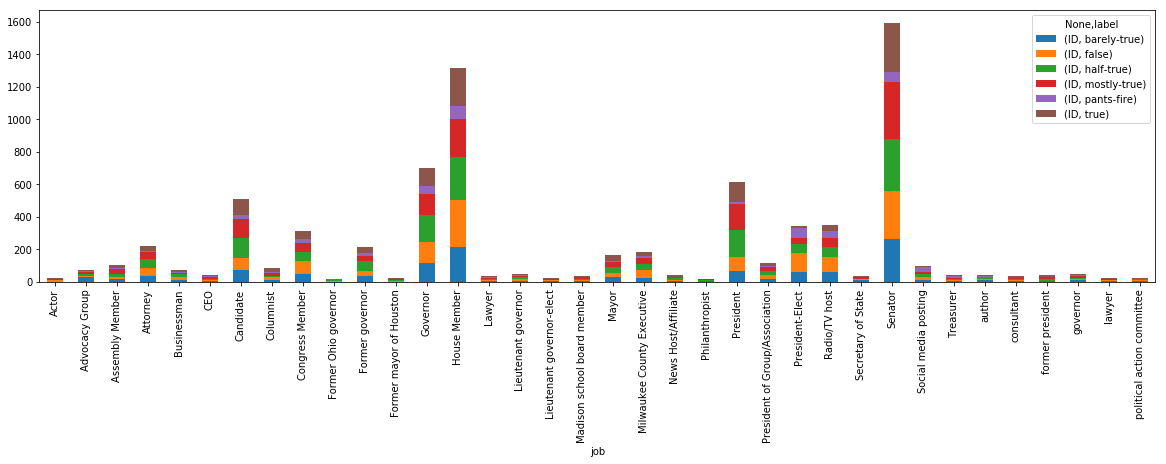

In [67]:
breakdown = by_label(jobs_df, 'job')
breakdown.unstack().plot(kind='bar', stacked=True, figsize=(20,5))

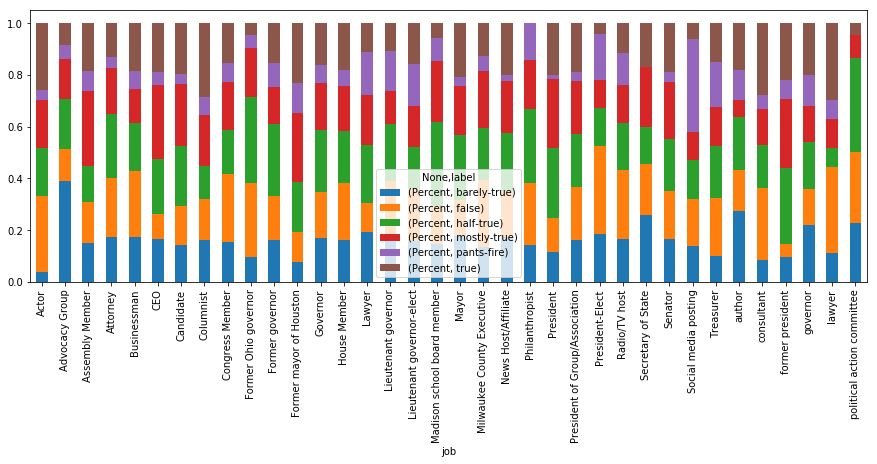

In [68]:
bd_norm = normalize(breakdown, 'job')
bd_norm.unstack().plot(kind='bar', stacked=True, figsize=(15,5))

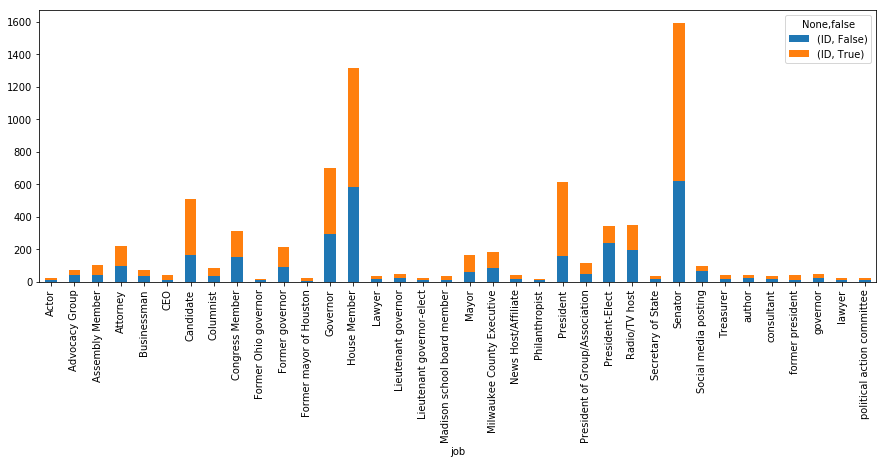

In [69]:
tf_breakdown = transform_tf(jobs_df, 'job')
tf_breakdown.unstack().plot(kind='bar', stacked=True, figsize=(15,5))

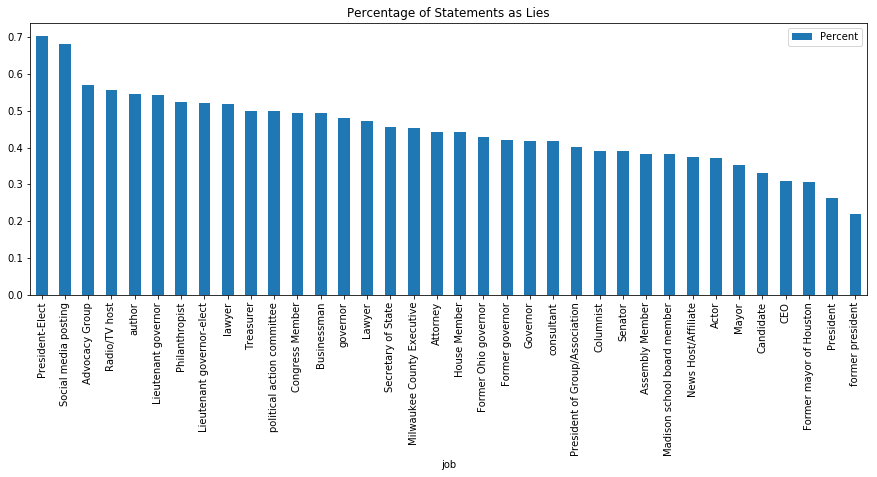

In [70]:
bd_norm = normalize_tf(tf_breakdown, 'job')
plot_truthfulness(bd_norm, 'job')

### Task 4: Interpretation
This analysis must be interpreted with knowledge of the time constraints of the dataset. In the years 2007-2017, there were only two President-Elects, one of whom is one of the most consistent liars as shown in the analysis above. Additionally, congresswoman may only refer to a very small number of people within the dataset. This can be said for many of the jobs, such as Ohio treasurer and House Majority Leader.

It is notable that Radio hosts, businessmen and attorneys are all fairly generic jobs that have high instances of falsehoods in this dataset.

## Task 5: Explore the party feature
Using similar analysis as above, we will explore one other relevant feature within the dataset, which is political party affiliation:
- Find a way to visualize how truth relates to this feature.

In [71]:
parties_df = df_raw.copy()
parties = jobs_df['party'].unique()
print("There are %d unique parties" % len(parties))
print("Some sample parties include:\n", parties)

There are 18 unique parties
Some sample parties include:
 ['republican' 'democrat' 'none' 'columnist' 'journalist' 'talk-show-host'
 'independent' 'constitution-party' 'organization' 'labor-leader'
 'libertarian' 'newsmaker' 'Moderate' 'state-official' 'activist'
 'business-leader' 'education-official' 'tea-party-member']


In [72]:
parties_cts = parties_df.groupby("party").statement.count()
parties = parties_cts[parties_cts > 20]
print("There are %d unique affiliations who appear more than 20 times within the dataset" % len(parties))
print("Some sample affiliations include:\n", parties[:5])

There are 12 unique affiliations who appear more than 20 times within the dataset
Some sample affiliations include:
 party
activist         45
columnist        44
democrat       4137
independent     180
journalist       49
Name: statement, dtype: int64


In [73]:
## Limit ourselves to only prominent speakers to remove edge cases
parties_df = parties_df[parties_df['party'].isin(parties.keys())]

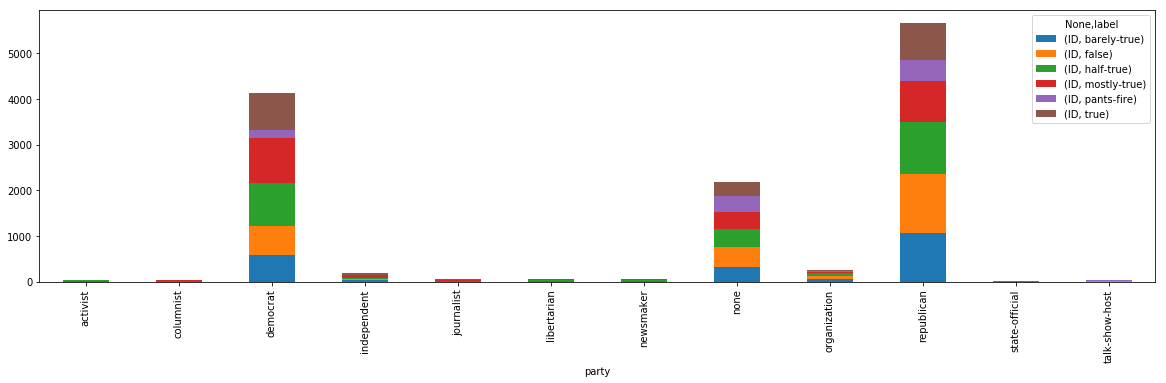

In [74]:
breakdown = by_label(parties_df, 'party')
breakdown.unstack().plot(kind='bar', stacked=True, figsize=(20,5))

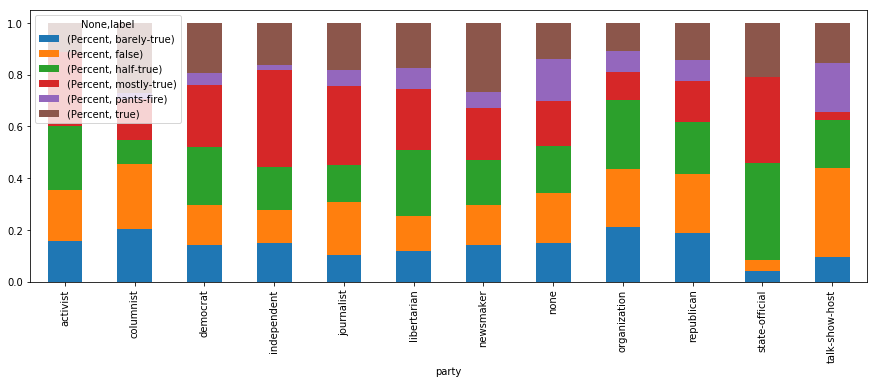

In [75]:
bd_norm = normalize(breakdown, 'party')
bd_norm.unstack().plot(kind='bar', stacked=True, figsize=(15,5))

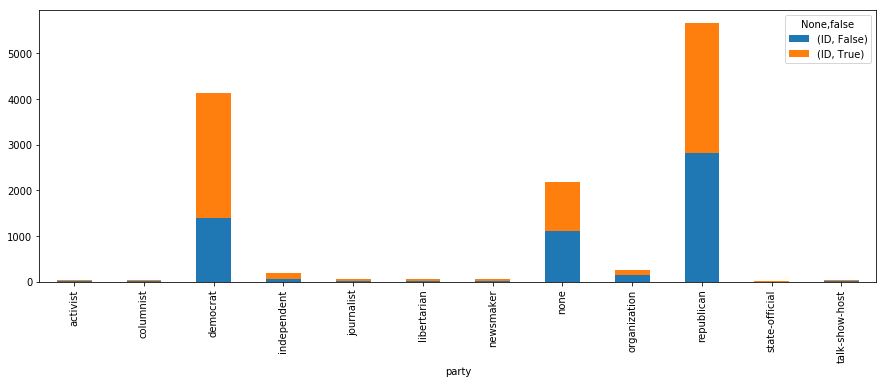

In [76]:
tf_breakdown = transform_tf(parties_df, 'party')
tf_breakdown.unstack().plot(kind='bar', stacked=True, figsize=(15,5))

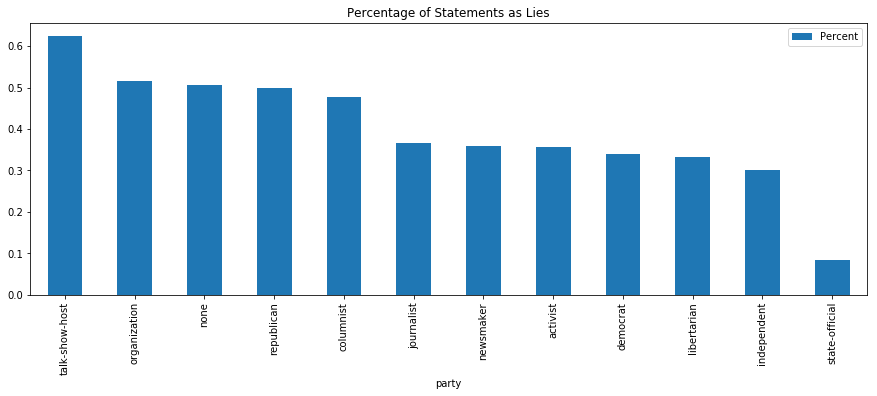

In [77]:
bd_norm = normalize_tf(tf_breakdown, 'party')
plot_truthfulness(bd_norm, 'party')

### Task 5: Interpretation
This task has some interesting results. Extreme values seem to be dominated not by the standard two American political parties. We see talk-show-host being by far the least truthful affiliation. This is interesting because talk shows very often have a political bias, but for purposes of this dataset they are not strictly affiliated. This also shows that this feature has a lot of redundance with the features above - job and speaker often define party affiliation.

## Task 6: Measure interaction between affiliation and job
Prior to this point, we have performed single variable analysis of the features within the dataset. Here we will begin looking at interactions between features. In this task, we want to analyze and visualize how the features interact. We do so by:
- Finding the jobs with the highest rate of lies.
- Finding the parties with the highest rate of lies.
- Find the job/party combinations with the highest rate of lies.
- Breakdown and visualize the effect party has on truthfulness for each of the high lie rate jobs.

In [78]:
# Capture jobs with more lies
job_false = df_raw[df_raw.label.isin(["false", "pants-fire", "barely-true"])].groupby("job").ID.count()
job_false_df = pd.DataFrame(job_false).reset_index()
job_false_df.columns = ['job', 'false_count']
job_false_df_max = job_false_df.sort_values(by='false_count' ,ascending=False).head(20)

In [79]:
# Capture parties with more lies
party_false = df_raw[df_raw.label.isin(["false", "pants-fire", "barely-true"])].groupby("party").ID.count()
party_false_df = pd.DataFrame(party_false).reset_index()
party_false_df.columns = ['party', 'false_count']
party_false_df_max = party_false_df.sort_values(by='false_count' ,ascending=False).head(20)

In [80]:
# Analyze both at the same time
party_job_false = df_raw[df_raw.label == "false"].groupby(["job", "party"]).ID.count()
party_job_false_df = pd.DataFrame(party_job_false).reset_index()
party_job_false_df.columns = ['job', 'party', 'false_count']
party_job_false_df_sorted = party_job_false_df.sort_values(by='false_count' ,ascending=False)

In [81]:
merge_party_job = party_job_false_df_sorted.merge(party_job_false_df_sorted, on='job')
merge_party_job = merge_party_job[(merge_party_job.party_x == 'republican') & (merge_party_job.party_y == 'democrat')]
merge_party_job = merge_party_job.sort_values(by='false_count_x', ascending=False)
data_matrix = merge_party_job.iloc[:4]
data_matrix

,job,party_x,false_count_x,party_y,false_count_y
1,House Member,republican,198,democrat,87
17,Senator,republican,193,democrat,85
27,Governor,republican,116,democrat,11
35,Congress Member,republican,71,democrat,12


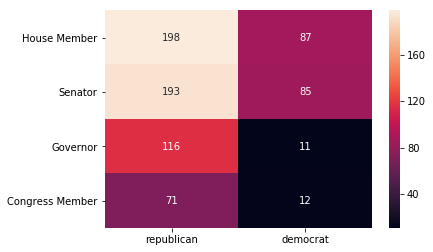

In [82]:
sns.heatmap(np.matrix(data_matrix[['false_count_x', 'false_count_y']]), annot=True, fmt="d", xticklabels=['republican', 'democrat'], yticklabels=data_matrix['job'])

It appears as though republican governors have drastically higher rate of lying than democrats. We observed before that republicans had only a marginally higher lying rate. So we want to see if the recorded governor statements themselves lean toward statements from republican governors.

In [83]:
governors = jobs_df[jobs_df['job']=='Governor']
governors[['speaker', 'job', 'party']].drop_duplicates().head()

,speaker,job,party
0,mike-pence,Governor,republican
1,rick-perry,Governor,republican
17,chris-christie,Governor,republican
58,rick-scott,Governor,republican
228,john-kitzhaber,Governor,democrat


In [84]:
governors.groupby('party').job.count()

party
democrat       81
republican    621
Name: job, dtype: int64

### Task 6: Interpretation
In this task we see some possible interaction between the features. We noted earlier that the rate of lies was higher for Republicans than democrats, but this seems especially pronounced for governors. This leads us to question whether or not there simply tend to be more republican governors sampled than democrats. This ends up being the case, with over 6 times the amount of statements taken from republican governors than democratic governors. This reveals a bias within the sampling of the dataset which we must be careful for when constructing models or trying to make future analysis.

## Task 7: Create a rudimentary model
For this project, we will ultimately be using the findings above as well as additional tools to augment our dataset for underlying features. We will make an initial model in the exploration step simply to establish a baseline from which to improve.

While it is notable that this is not simply a machine learning exercise, we believe that improvement of the model can be some indication of relevance of the additionally analysis we perform in augmenting the data set to expose new relations that can hopefully be predictive.

In [85]:
# Data Loading

train_data = load_data(TRAIN_PATH)
test_data = load_data(TEST_PATH)
valid_data = load_data(VALID_PATH)

train_data.label = convert_label(train_data)
test_data.label = convert_label(test_data)
valid_data.label = convert_label(valid_data)

train_data.drop(columns=["ID", "statement", "barely_true_cts", "false_cts", "half_true_cts", "mostly_true_cts", "pants_on_fire_cts"], inplace=True)
test_data.drop(columns=["ID", "statement", "barely_true_cts", "false_cts", "half_true_cts", "mostly_true_cts", "pants_on_fire_cts"], inplace=True)
valid_data.drop(columns=["ID", "statement", "barely_true_cts", "false_cts", "half_true_cts", "mostly_true_cts", "pants_on_fire_cts"], inplace=True)

In [86]:
# Preprocess data
train_data = preprocess_data(train_data)
test_data = preprocess_data(test_data)
valid_data = preprocess_data(valid_data)

In [87]:
# Converting in categorical variables
dummy_train = pd.get_dummies(train_data)
dummy_test = pd.get_dummies(test_data)
dummy_valid = pd.get_dummies(valid_data)

In [88]:
# Fitting dummy test data

column_set = dummy_train.columns
columns_to_fit = dummy_test.columns
to_remove = set(columns_to_fit) - set(column_set)
to_add = set(column_set) - set(columns_to_fit)

# For each class of feature we did not find, we add this our set of features with all values as 0
for addable in to_add:
    dummy_test[addable] = 0

# For each class new class of features, we attempt to add it an 'Other' feature if it exists
# If not, we simply remove it
for removable in to_remove:
    original_name = removable.split('_')[:-1]
    original_name.append('Other')
    other_col = "_".join(original_name)
    if dummy_test.columns.contains(other_col):
        dummy_test[other_col] += dummy_test[removable]
    dummy_test.drop(removable, axis=1, inplace=True)
    
## Need to sort columns for ordering compatability!
dummy_test = dummy_test.reindex_axis(column_set, axis=1)

/home/mikanikos/anaconda3/envs/ada/lib/python3.6/site-packages/ipykernel_launcher.py:23: FutureWarning: '.reindex_axis' is deprecated and will be removed in a future version. Use '.reindex' instead.


In [89]:
# Prepare data 

X_tr = dummy_train.iloc[:,1:].values
y_tr = dummy_train.iloc[:,0].values
X_te = dummy_test.iloc[:,1:].values
y_te = dummy_test.iloc[:,0].values

X_tr, y_tr = shuffle(X_tr, y_tr)
X_te, y_te = shuffle(X_te, y_te)

In [90]:
# Standardizing data

std_scaler = StandardScaler()
X_tr = std_scaler.fit_transform(X_tr)
X_te = std_scaler.transform(X_te)

/home/mikanikos/anaconda3/envs/ada/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/mikanikos/anaconda3/envs/ada/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/mikanikos/anaconda3/envs/ada/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [59]:
# Training and de-factorization

classifier = RandomForestClassifier(n_estimators = 100)
classifier.fit(X_tr, y_tr)
probs = classifier.predict(X_te)

In [60]:
# Confusion matrix
pd.crosstab(y_te, probs, rownames=['Actual'], colnames=['Predicted'])

Predicted,-2,-1,0,1,2,3
Actual,,,,,,
-2,26,22,15,12,12,5
-1,25,57,47,54,35,31
0,8,49,33,55,48,19
1,7,54,25,76,62,41
2,3,45,31,71,51,40
3,4,44,18,46,49,47


In [61]:
# Accuracy
accuracy_score(y_te, probs)

0.22888713496448304

In [62]:
# F1 score
f1_score(y_te, probs, average="micro")

0.22888713496448307

### Task 7: Interpretation
Our rudimentary model has very low accuracy in classifying the testing data but that was expected given the small size of the dataset and the result reported in the Liar dataset paper.

## Data augmentation with politifact data

Here we try to augment our data with the politifact API in order to analyze some other interesting meta-features about statements.

In [91]:
# Loading data from politifact
pol_train_set = pd.read_pickle("data/train_politifact")
pol_test_set = pd.read_pickle("data/test_politifact")
pol_valid_set = pd.read_pickle("data/valid_politifact")

In [92]:
poli_data = pd.concat([pol_train_set, pol_test_set, pol_valid_set], axis=0, sort=False)
poli_data = poli_data.sample(frac=1).reset_index()

In [93]:
poli_data.columns

Index(['index', 'art', 'author', 'canonical_url', 'edition', 'editor',
       'facebook_headline', 'id', 'in_future', 'is_pundit', 'make_public',
       'preview', 'researcher', 'resource_uri', 'ruling', 'ruling_comments',
       'ruling_comments_date', 'ruling_date', 'ruling_headline',
       'ruling_headline_slug', 'ruling_link_text', 'ruling_state',
       'source_documents', 'sources', 'speaker', 'statement',
       'statement_context', 'statement_date', 'statement_type', 'subject',
       'target', 'twitter_headline'],
      dtype='object')

In [94]:
# Merging with Politifact data with the Liar dataset

df_raw["id_clean"] = df_raw.ID.str[:-5]
df_raw.id_clean = pd.to_numeric(df_raw.id_clean)
df_raw_aug = poli_data.merge(df_raw, left_on="id", right_on="id_clean")

In [95]:
df_raw_aug.head(5)

,index_x,art,author,canonical_url,edition,editor,facebook_headline,id,in_future,is_pundit,...,job,state,party,barely_true_cts,false_cts,half_true_cts,mostly_true_cts,pants_on_fire_cts,context,id_clean
0,9098,"[{'brightcove': '', 'caption': 'Hillary Clinto...","[{'email_address': 'ljacobson@politifact.com',...",/truth-o-meter/statements/2015/may/07/hillary-...,"{'adkey': 'Editions', 'advalue': 'National', '...","[{'email_address': 'aholan@poynter.org', 'firs...",None,10810,False,False,...,Candidate,New York,democrat,40.0,29.0,69.0,76.0,7.0,Ad,10810
1,6083,"[{'brightcove': '', 'caption': 'A Snopes joke ...",[{'email_address': 'jgreenberg@politifact.com'...,/punditfact/statements/2015/jun/18/breitbart/n...,"{'adkey': 'Editions', 'advalue': 'Punditfact',...",[{'email_address': 'asharockman@politifact.com...,"No, a pear was not the original symbol of Cali...",10960,False,False,...,NaN,NaN,none,0.0,0.0,0.0,0.0,2.0,Article,10960
2,1464,[],"[{'email_address': 'oregoniandc@gmail.com', 'f...",/oregon/statements/2011/jan/17/greg-walden/rep...,"{'adkey': 'Editions', 'advalue': 'Oregon', 'ed...","[{'email_address': 'tbottomly@oregonian.com', ...",None,3057,False,False,...,House Member,Oregon,republican,3.0,0.0,1.0,0.0,0.0,Speech,3057
3,995,[],"[{'email_address': 'aholan@poynter.org', 'firs...",/truth-o-meter/statements/2008/oct/30/barack-o...,"{'adkey': 'Editions', 'advalue': 'National', '...","[{'email_address': 'ahollyfield@tampabay.com',...",None,835,False,False,...,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Ad,835
4,681,[],"[{'email_address': 'tferan@plaind.com', 'first...",/ohio/statements/2012/jul/20/josh-mandel/josh-...,"{'adkey': 'Editions', 'advalue': 'Ohio', 'edit...","[{'email_address': 'rhiggs@plaind.com', 'first...",None,6295,False,False,...,Treasurer,Ohio,republican,4.0,5.0,4.0,5.0,6.0,News Program,6295


## Task 8: Date tracking
In this task we try to have a first look at some of the features gathered from politifact. We were surprised that the Liar dataset didn't include a date column and we thought it could be interesting to see the trend of lies over the last few years.

In [96]:
df = pd.DataFrame(df_raw_aug[["statement_date", "label", "ID"]])

In [97]:
df["year"] = df.statement_date.str[:4]
df.drop(df[(df["year"] == "1995") | (df["year"] == "2000") | (df["year"] == "2002")].index, inplace=True)

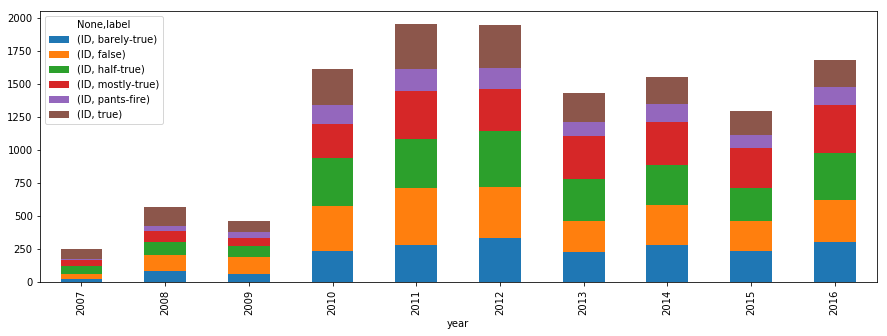

In [98]:
breakdown = by_label(df, 'year')
breakdown.unstack().plot(kind='bar', stacked=True, figsize=(15,5))

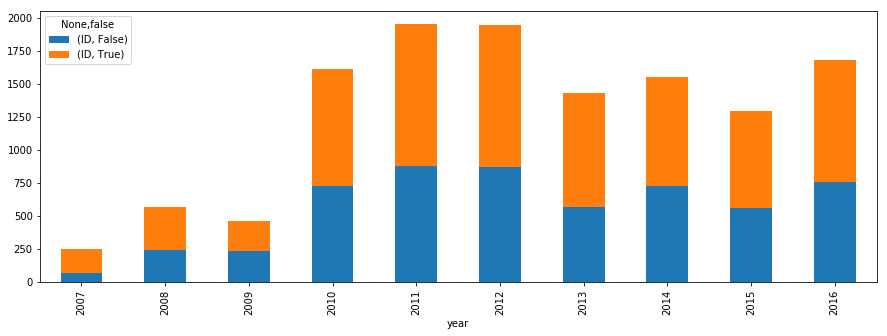

In [99]:
tf_breakdown = transform_tf(df, 'year')
tf_breakdown.unstack().plot(kind='bar', stacked=True, figsize=(15,5))

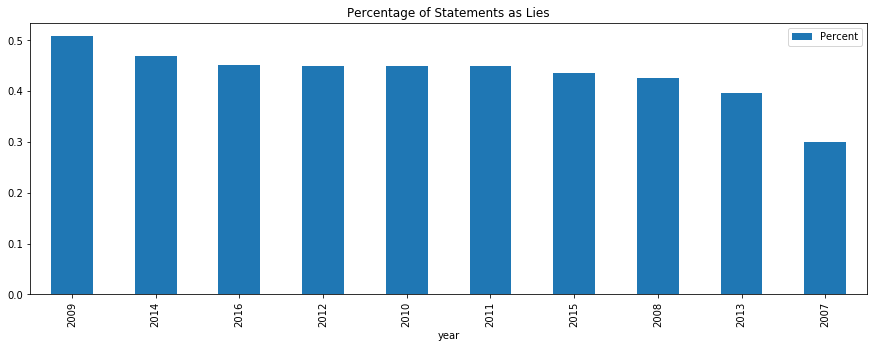

In [100]:
bd_norm = normalize_tf(tf_breakdown, 'year')
plot_truthfulness(bd_norm, 'year')

## Task 9: Publications tracking

In this task we try to have a first look at some of the features gathered from politifact. We were surprised that the Liar dataset didn't include a date column and we thought it could be interesting to see the trend of lies over the last few years.

In [101]:
df_raw_aug["publication"] = df_raw_aug.author.apply(lambda x: x[0].get('publication').get('publication_name') if x else "")
publ_label = df_raw_aug[["ID", "label", "publication"]]
publ_label.drop(publ_label[publ_label.publication == ""].index, inplace=True)

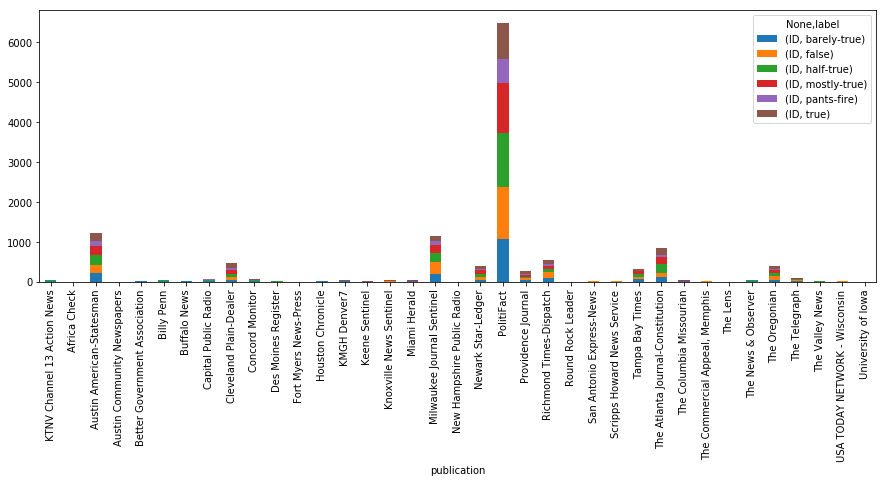

In [102]:
breakdown = by_label(publ_label, 'publication')
breakdown.unstack().plot(kind='bar', stacked=True, figsize=(15,5))

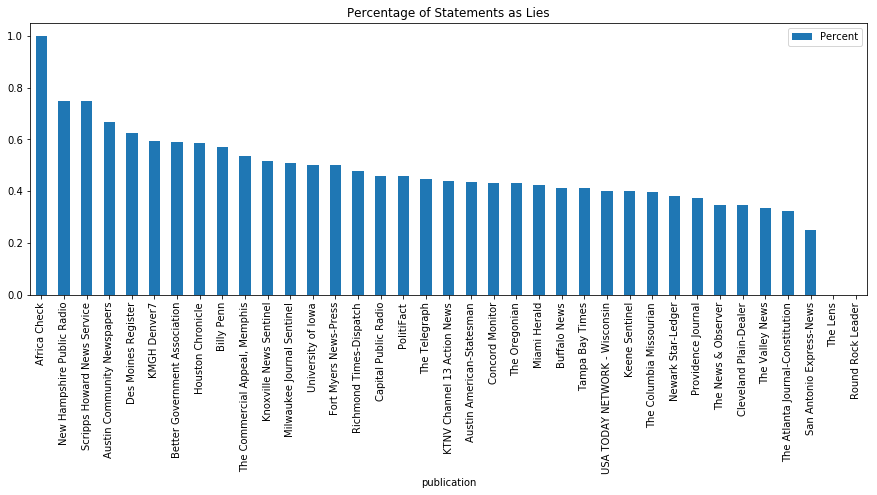

In [103]:
tf_breakdown = transform_tf(publ_label, 'publication')
bd_norm = normalize_tf(tf_breakdown, 'publication')
plot_truthfulness(bd_norm, 'publication')

### Overall Interpretations

Until this point, we have gathered insights to proceed in augmenting the data set. In the future, we will see if augmentations can help improve this accuracy (indicating that underlying features might be important in discrimination of the data) as well try to see how generalizable these findings are to other datasets. In specific, we note that the topic, speaker and party each seemed to be reasonable predictive features. We have noted in many places that anonymity seemed to increase lack of truthfulness. Additionally, we found that the location of the statement did not seem to be a particularly strong indicator as most location trends seemed to only hold in certain cases. We also found some inherent biases in the collection of the dataset, whereby some job statements were sampled much higher for republicans than democrats. This would lead a classifier, such as the rudimentary classifier we build, to associate certain jobs with lack of truthfulness, even if it is the result of a sampling bias, or possibly reflective of a disparity of representations in that job role.

One of the only columns we did not explore was in the statement itself. This is not an easily parsible column, as each statement will tend to only appear once. To analyze this feature we will need to perform some NLP tasks to see if some linguistic aspects of the statement can be interpreted to predictive features.

# Comparative Analysis
#### This section of the notebook outlines comparative analysis to further investigate earlier findings.

## Task 1: Compare Different Types of Speakers
In the exploration of the data, we found large differences in truthfulness of different speakers. A common theme of many of the highest lying rate sources was anonymity; we noted that anonymous sources such as Facebook and chain emails were some of the least truthful sources while named speakers were typically more truthful. Our conjecture is that accountability plays some role in truthfulness.

We note that it could have been that case that some other factor (such as subject of statement) was expressed more by certain sources, which would cause the disparity for reasons not inherent to the source. As a concrete example, we found that medicare and terrorism were notoriously unreliable topics. It could be the case that our most unreliable sources simply spoke on those topics more.

To investigate further, we will:
- Create representative groups between anonymous sources and named speakers.
- We will attempt to control for subject.
- We will determine if the distribution of truthfulness of statements is different between the two groups when controlling for other determiners.

In [104]:
## Define anonymous sources
anonymous_sources = ['facebook-posts', 'chain-email', 'blog-posting', 
                     'internet-commenters','instagram-posts']
anonymous_df = df_raw[df_raw['speaker'].isin(anonymous_sources)]
anonymous_df = subject_split(anonymous_df)

## Define named sources - represents either a person or a titled group of people
named_df = df_raw[~df_raw['speaker'].isin(anonymous_sources)]
named_df = subject_split(named_df)

In [105]:
## TODO : Donut plot with subgroups?

def plot_donut(df, title=""):
    colormap = ListedColormap(sns.color_palette("coolwarm", 6)) 
    truth_values = ['true','mostly-true','half-true','barely-true','false','pants-fire']
    plottable = df.groupby('label').ID.count()
    ## Ensures sorting iterable matches form of Series
    for value in truth_values:
        if value not in plottable.keys():
            placeholder = pd.Series(0)
            placeholder.index = [value]
            plottable = plottable.append(placeholder)
            
    ## Order by truth_values so that plot is on spectrum
    plottable = plottable.reindex(index=truth_values)
    sizes = plottable.values
    names = plottable.keys()

    plt.pie(sizes, labels=names, colors=colormap.colors)

    # add a circle at the center
    my_circle=plt.Circle((0,0), 0.7, color='white')
    p=plt.gcf()
    p.gca().add_artist(my_circle)
    plt.title(title)
    plt.show()


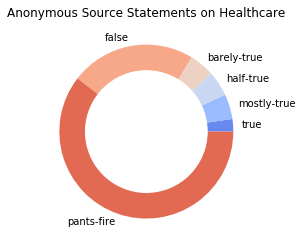

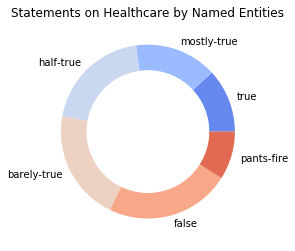

In [106]:
## Isolate only the subject we wish to examine - first we examine healthcare (a highly untruthful topic)
anon_healthcare = anonymous_df[anonymous_df['subject']=='health-care']
named_healthcare = named_df[named_df['subject']=='health-care']

plot_donut(anon_healthcare, "Anonymous Source Statements on Healthcare")
plot_donut(named_healthcare, "Statements on Healthcare by Named Entities")

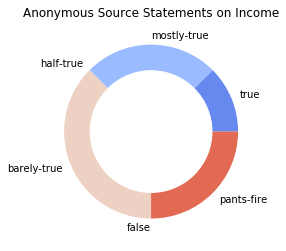

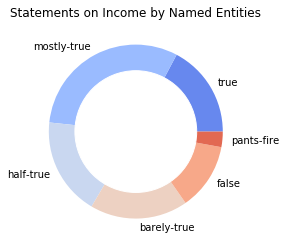

In [107]:
## Isolate only the subject we wish to examine - first we examine healthcare (a highly untruthful topic)
anon_income = anonymous_df[anonymous_df['subject']=='income']
named_income = named_df[named_df['subject']=='income']

plot_donut(anon_income, "Anonymous Source Statements on Income")
plot_donut(named_income, "Statements on Income by Named Entities")

We see above that for both our most lied about topic and our least lied about topic, the anonymous sources group has a substantially higher tendency for both 'false' and 'pants-fire' statements. This indicates that even controlling for topic of discussion, the anonymous source group still is less trustworthy.

We additionally the much higher portion of 'pants-fire' lies as opposed to 'false' and 'barely-true' gradings for the anonymous group.

# Analysis of Numerical References
#### This section of the notebook outlines analysis on the way speakers reference numbers in their statements.

## Task 1: Quantify Obedience to Benford Distribution
Benford's Law (https://en.wikipedia.org/wiki/Benford%27s_law) is a typical distribution of leading numbers within numeric data spanning multiple orders of magnitude. Leading digits are, in general, not normally distributed but heavily biased towards smaller values. It is typically, but not always observed, when taking aggregated data where such data exists on many orders of magnitude. Fitting to Benford's distribution has been used to detect financial fraud, and humanly generated numbers often don't obey it.

In this analysis, we will quantify how well the instances of numbers in the statements obey to Benford's law with the hope that lies (human-generated numbers) will be exposed by their lack of conformity to prediction.

To investigate further, we will:
- Parse the speaker statements for references to numbers. The exact methodology is within numberparser.py
- We will select different subsets of the data and take the distribution of leading digits in numbers referenced over that subset.
- We will see how agreement with Benford's law (measured with chi squared metric, and p-values) varies among different subsets of the data (such as different speakers, different truth labels, etc.) This methodology is credited to (http://evoq-eval.siam.org/Portals/0/Publications/SIURO/Vol1_Issue1/Testing_for_the_Benford_Property.pdf?ver=2018-03-30-130233-050)

In [108]:
## We have put a lot of utilities, including some utilities we have found online
## (and therefore credited to their author) within numberparser.py. Because this code
## is so verbose and only culminates in a single task (finding references to numbers within speech)
## we have kept it out of the notebook.
import numberparser

In [109]:
def get_c2(obs_dict):
    '''Gets the chi_squared measurement from observed frequencies, given the expectation of Benford distribution
    Params - obs_dict : dictionary of observations
    Returns - chisquare and p-value metrics
    '''
    ## Define expected Benford distribution
    benford = {1:0.3010, 2:0.1761, 3:0.1249, 4:0.0969, 5:0.0792, 6:0.0669, 7:0.0580, 8:0.0512, 9:0.0458}
    obs = []
    exp = []
    for i in range(1, 10):
        obs.append(obs_dict[i])
        exp.append(benford[i]*obs_dict['total'])
    return scipy.stats.chisquare(obs, f_exp=exp)
        

In [110]:
benfs = pd.DataFrame(columns=['true','mostly-true','half-true','barely-true','false','pants-fire'], index=['chi_squared', 'p_value'])
for label in benfs.columns:
    freqs = numberparser.leading_digits(df_raw[df_raw['label']==label])
    desc = get_c2(freqs)
    benfs[label]['chi_squared'] = desc.statistic
    benfs[label]['p_value'] = desc.pvalue
benfs

,true,mostly-true,half-true,barely-true,false,pants-fire
chi_squared,48.7003,52.5685,87.8695,43.4278,93.8461,20.2651
p_value,7.25642e-08,1.30698e-08,1.25785e-15,7.2962e-07,7.68488e-17,0.00937834


In [111]:
benfs = pd.DataFrame(columns=['barack-obama', 'donald-trump', 'hillary-clinton', 'chain-email'], index=['chi_squared', 'p_value'])
for label in benfs.columns:
    freqs = numberparser.leading_digits(df_raw[df_raw['speaker']==label])
    desc = get_c2(freqs)
    benfs[label]['chi_squared'] = desc.statistic
    benfs[label]['p_value'] = desc.pvalue
    
benfs

,barack-obama,donald-trump,hillary-clinton,chain-email
chi_squared,23.5116,24.8549,17.4877,20.9518
p_value,0.00276588,0.00164501,0.025413,0.0072767


### Interpretation
Overall we do not see strong strong conformity to Benford's law. We do see partial conformity within the dataset - the distribution of leading digits seems to resemble the Benford distribution much more closely than if they were uniform. The dataset as a whole, as well as each of the subsets selected, maintain the trend of decreasing proportionality of each successive leading digit.

Surprisingly, we do not see any noticeable predictive power based upon conformity to Benford distribution. For example, the 'pants-fire' portion of the dataset has a lower chi-squared value than 'true' and even 'chain-email' has lower chi-squared than 'barack-obama'. In both of these cases, the less truthful portion of the dataset has better conformity to Benford's law.

## Task 2: Compare numeric statements to non-numeric statements.
It could be useful to compare numeric and non-numeric statements to see if speakers are more or less likely to lie in statements regarding quantities. These quantities can be dates, currency or amounts and it is possible that a speaker may be more prone to lying when quantities are involved. (for example, false figures on debt, deficit and GDP may be used as a fear-mongering tactic)

To investigate further, we will:
- Split the dataset between statements mentioning numbers and statements with no mention of numbers.
- Measure the relative likelihood of each category of truthfulness between the two subsets.
- Quantify any disparity seem, noting that the null hypothesis would be that mentioning numeric values would not influence truthfulness.

In [112]:
## Create columns we can split data by - uses utilities defined in numberparser.py
df_nums = df_raw.copy()
df_nums['numbers'] = numberparser.get_nums_from_dataframe(df_nums)
df_nums['has_num'] = df_nums['numbers'].apply(lambda x: x!=[])
df_nums.head(2)

,index,ID,label,statement,subject,speaker,job,state,party,barely_true_cts,false_cts,half_true_cts,mostly_true_cts,pants_on_fire_cts,context,id_clean,numbers,has_num
0,1951,13278.json,false,State Department officials actually directed c...,ethics,mike-pence,Governor,Indiana,republican,8.0,10.0,12.0,5.0,0.0,Ad,13278,[],False
1,5065,4414.json,half-true,Michael Dukakis created jobs three times faste...,jobs,rick-perry,Governor,Texas,republican,30.0,30.0,42.0,23.0,18.0,Debate,4414,[3],True


In [113]:
## Split into two disjoint sets
df_has_num = df_nums[df_nums['has_num']]
df_no_num = df_nums[~df_nums['has_num']]
print("%d statements contain numbers" % len(df_has_num))
print("%d statements do not contain numbers" % len(df_no_num))

6051 statements contain numbers
6740 statements do not contain numbers


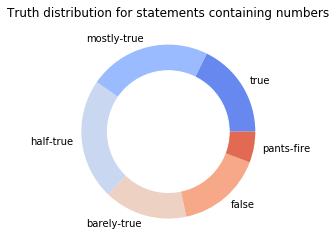

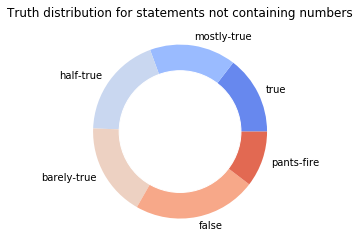

In [114]:
plot_donut(df_has_num, "Truth distribution for statements containing numbers")
plot_donut(df_no_num, "Truth distribution for statements not containing numbers")

Here we see a visually noticeable difference between the two subsets. It appears that pants-fire and false statements seem to be more prevalent in statements not containing numbers. This could possible be due to the precise nature of numbers - while it is very possible for somebody to lie about a numeric statement, it could be the case that statements containing numbers reflect more research on part of the speaker.

We wish to quantify whether this is likely to be a random result. We will compute the p-value of the relationship, that is the likelihood that the null hypothesis (no influence on truthfulness of this feature) could have generated this result.

In [115]:
## First we need make calculate expected distributions:
expected_dist = df_raw.groupby('label').ID.count().values
proportion = lambda x: len(x)/len(df_raw)
## Instead of using default f_exp (which is uniform), we use the expected distribution based off of the aggregate
p1 = scipy.stats.chisquare(df_has_num.groupby('label').ID.count().values, f_exp=expected_dist*proportion(df_has_num)).pvalue
p2 = scipy.stats.chisquare(df_no_num.groupby('label').ID.count().values, f_exp=expected_dist*proportion(df_no_num)).pvalue
print("p-value for chi-squared distribution of statements with numbers =", p1)
print("p-value for chi-squared distribution of statements without numbers =", p2)

p-value for chi-squared distribution of statements with numbers = 2.4819646777836233e-30
p-value for chi-squared distribution of statements without numbers = 4.237916141814983e-27


### Interpretation
In this we let our null-hypothesis be that the distribution of both subsets is generated in the same proportions as within the aggregate dataset. The low p-value here indicates a very poor measurement of fitness. This indicates some significance in differentiating a statement based upon whether or not it mentions numbers. This suggests that statements involving numeric figures seem to be more biased for truthfulness, and not in a way that is likely to have been generated by the same probabilities that generated the aggregate dataset.

At the same time, it is important to be cautious with this interpretation for three reasons:
- First, it does not seem like a usable strategy to differentiate between fake news, since both classes of statements have lots of representation from all truth groups.
- Secondly, this dataset is manually sampled with specific care to distribution of truthfulness. With only this consideration, it would have been possible for some underlying bias within the collection to play a role. Furthermore, we assert the null hypothesis as the aggregate distribution of truthfulness, but this is not to be confused with the chance for truthfulness of statements taken at random (the 'true' truthfulness distribution which is impossible for us to measure or quantify).
- Thirdly, this could simply be an expression of some other factor within the dataset. It could be that the case that topics that involve numeric figures (such as income, crime and debt) were more truthful in general. (although it worth mentioning that numeric figures would also be expected to show up in medicare, history and climate chance)